# Descriptive stats and explore internal standards

## Content

1. Load modules
2. Import data
3. Check overall number of peaks and values 
4. Plot characteristics of internal standards
    - Plot distribution of RT and intensities in targeted tables
    - Match IS intensities of targeted and untargeted data

## 1. Load modules

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from datetime import datetime, timedelta

## 2. Import data

In [2]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

# Load tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

time_info = pd.read_csv('curated_input/time_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

targeted_ms_paths = glob.glob(\
    'curated_input/targeted_per_strain/*_input_targeted_*')
targeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]

untargeted_ms_paths = glob.glob(\
    'intermed_results/01_noBadInjections/data/untargeted_per_strain/*_input_untargeted_*')
untargeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in untargeted_ms_paths]
    

del(targeted_ms_paths, untargeted_ms_paths)

## 3. Check overall number of peaks and values
(mostly untargeted data)

Get data:

In [3]:
peak_counts = []
rt_all = []
mass_all = []
int_min_max =[]

for tab in untargeted_perS_list:
    #tab = untargeted_perS_list[30]
    tab_vals = tab.loc[:,tab.columns.str.endswith('(raw)')]
    int_vals = [min(np.min(tab_vals)), max(np.max(tab_vals))]
    rt_vals = tab.loc[:,'RT']
    mass_vals = tab.loc[:,'Mass']
    peak_counts.extend(tab_vals.count())
    rt_all.extend(rt_vals)
    mass_all.extend(mass_vals)
    int_min_max.extend(int_vals)
    
    
    
del(tab_vals, int_vals, rt_vals, mass_vals)

In [8]:
# Mean number of peaks per measurement
np.mean(peak_counts)

6266.347402597403

Plot number of signals over retention time:

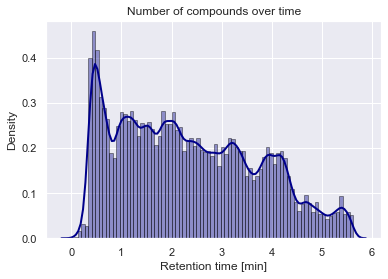

In [4]:
sns.distplot(rt_all, hist=True, kde=True, 
             bins=80, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Number of compounds over time')
plt.xlabel('Retention time [min]')
plt.ylabel('Density')

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
                'overall_num_peaks_over_time.pdf',\
                bbox_inches='tight')

plt.show()

plt.close('all')

Get some overall stats:

In [5]:
print('Mean number of signals per measurement (untargeted):', round(np.mean(peak_counts),2))

print('Min RT:', min(rt_all))
print('Max RT:', max(rt_all))

print('Min mass:', min(mass_all))
print('Max mass:', max(mass_all))

print('Min Intensity:', min(int_min_max))
print('Max Intensity:', max(int_min_max))

Mean number of signals per measurement (untargeted): 6255.95
Min RT: 0.06
Max RT: 5.621
Min mass: 98.9839
Max mass: 997.1577
Min Intensity: 5675.0
Max Intensity: 103000000.0


Quick look at number of signals per measurement in targeted data:

In [6]:
tar_peak_counts = []

for tab in targeted_perS_list:
    tab_vals = tab.loc[:,tab.columns.str.endswith('Area')]
    tar_peak_counts.extend(tab_vals.count())

print('Mean number of signals per measurement (targeted):', \
      round(np.mean(tar_peak_counts),2))

Mean number of signals per measurement (targeted): 58.0


## 4. Identify internal standards and plot characteristics

Define standards:

In [4]:
IS_list_full_name = ['IS_SPARTEINE', 'IS_EMETINE','IS_CAFFEINE',
                     'IS_YOHIMBINE', 'IS_SULFAMETHOXAZOLE', 'IS_EYTHROMYCINE',
                     'IS_MIFEPRISTONE', 'IS_IPRIFLAVONE'] # names in targeted data tables

IS_mass_refs =  [
        234.20960, #sparteine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:28827
        480.29881, #emetine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:4781
        194.08038, #caffeine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:27732
        354.19434, #yohimbine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:10093
        253.05211, #sulfamethoxazole: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:9332
        733.46124, #erythromycin A (questionalble): https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:42355
        429.26678, #mifepristone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:50692
        280.10994  #ipriflavone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:31719
        ]

IS_dict = dict(zip(IS_list_full_name, IS_mass_refs))

IS_total_names = ['sparteine', 'emetine', 'caffeine', 'yohimbine','sulfamethoxazole', \
                  'erythromycin A', 'mifepristone', 'ipriflavone']

Get RT and intensity range of IS in targeted data (including measurement IDs for matching with time stamp info):

In [5]:
IS_list =  list(IS_dict.keys())

In [6]:
# retention times
IS_rts = []
IS_mIDs = []

for IS_name in IS_list:
    
    IS_vals = []
    mIDs = []
    
    for cur_table in targeted_perS_list:
        new_vals = cur_table.loc[cur_table.index.str.startswith(IS_name),\
                                 cur_table.columns.str.endswith('RT')].\
                                 values.tolist()[0]
        col_names = cur_table.columns[cur_table.columns.str.endswith('RT')]
        
        IS_vals.extend(new_vals)
        mIDs.extend(col_names)
        
    IS_rts.append(IS_vals)
    IS_mIDs.append(mIDs)
    
del(new_vals, col_names)

In [7]:
# Transform mIDs for matching (remove '-RT' from end)
mIDs_fixed = []

for name_list in IS_mIDs:
    names_fixed = [name[:-3] for name in name_list]
    mIDs_fixed.append(names_fixed)

In [8]:
IS_rt_df = pd.DataFrame(dict(zip(IS_list_full_name, IS_rts)), index = mIDs_fixed[0])

In [9]:
# intensities
IS_ints =  []

for IS_name in IS_list:
    
    IS_vals = []
    
    for cur_table in targeted_perS_list:
        new_vals = cur_table.loc[cur_table.index.str.startswith(IS_name),\
                                 cur_table.columns.str.endswith('Area')].\
                                 values.tolist()[0]
        IS_vals.extend(new_vals)
        
    IS_ints.append(IS_vals)

Plot raw distribution of ISs:

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


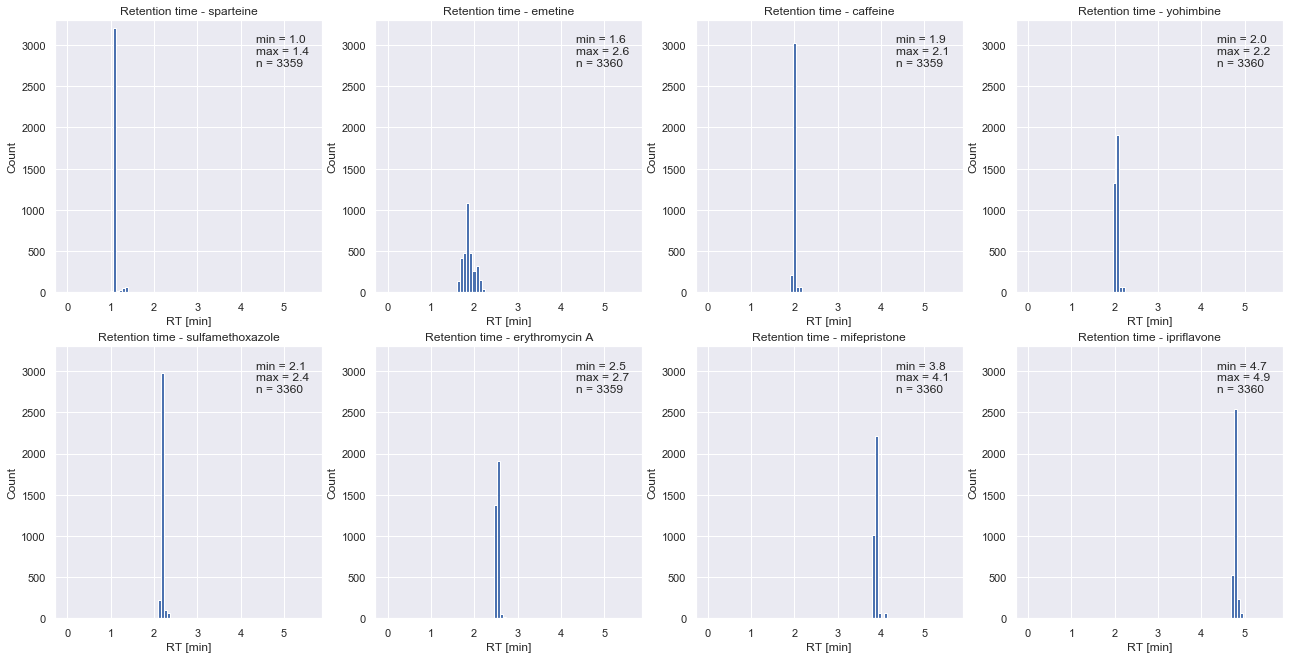

In [12]:
plt.figure(figsize = (22,11))

for i, plot_dat in enumerate(IS_rts, start = 1):

    plt.subplot(2, 4, i)
    plt.hist(plot_dat, bins = 80, range = (0,5.6))
    plt.title('Retention time - '+ IS_total_names[i-1])
    plt.ylim(0, 3300)
    plt.xlabel('RT [min]')
    plt.ylabel('Count')
    plt.text(4.35, 2750, 'min = '+ str(round(min(plot_dat),1)) + '\n' + \
             'max = ' + str(round(max(plot_dat),1)) + '\n' + \
                 'n = ' + str(sum(~np.isnan(plot_dat))))
    
plt.savefig('intermed_results/02_general_and_IS_stats/'+\
                'IS_rt_dists.pdf',\
                bbox_inches='tight')
plt.show()

plt.close('all')

Plot IS RTs over measurements:

In [10]:
# Convert time string to datetime type
time_info['date_time'] = time_info['date_time'].apply(lambda x: \
                                    datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))#

# test
# time_info.iloc[0,0]

TypeError: strptime() argument 1 must be str, not Timestamp

In [11]:
# add time stamp to rt data frame
t_stamp_col = []

for idx in IS_rt_df.index:
    t_stamp_col.append(time_info.loc[idx, 'date_time'])

IS_rt_df['date_time'] = t_stamp_col

In [12]:
# add strain as column
strain_col = []

for idx in IS_rt_df.index:
    strain_col.append(idx.split('-')[3])

IS_rt_df['strain'] = strain_col

# add time point column
#TP_col = []

#for idx in IS_rt_df.index:
#    TP_col.append(idx.split('-')[4])

#IS_rt_df['time_point'] = TP_col

In [13]:
# add RT difference to median columns

RT_medians = [np.nanmedian(vals) for vals in IS_rts]

In [14]:
IS_rt_diffs = []

for i, vals in enumerate(IS_rts):
    
    diff_vals = []
    
    for val in vals:
        rt_diff = val-RT_medians[i]
        diff_vals.append(rt_diff)
    
    IS_rt_diffs.append(diff_vals)


In [15]:
is_diff_names = [name+'_diff' for name in IS_list_full_name]

for i, diff_name in enumerate(is_diff_names):
    IS_rt_df[diff_name] = IS_rt_diffs[i]


Plot histogram of measurements

In [28]:
max(IS_rt_df['date_time']) - min(IS_rt_df['date_time'])

Timedelta('89 days 23:34:00')

In [43]:
IS_rt_df[50:100]

IS_SPARTEINE  IS_EMETINE  IS_CAFFEINE  \
MZ002H-Pool05-P001B2-S006-T00         1.090       1.850        1.973   
MZ002H-Pool05-P001B2-S006-T12         1.089       1.861        1.973   
MZ002H-Pool06-P001B2-S006-T12         1.087       1.858        1.970   
MZ002H-Pool06-P001B2-S006-T00         1.099       1.848        1.971   
MZ002H-Pool07-P001B2-S006-T00         1.077       1.894        2.017   
MZ002H-Pool07-P001B2-S006-T12         1.075       1.914        2.014   
MZ002H-Pool08-P001B2-S006-T00         1.075       1.903        2.015   
MZ002H-Pool08-P001B2-S006-T12         1.074       1.902        2.013   
MZ002H-Pool09-P001B2-S006-T00         1.077       1.849        1.972   
MZ002H-Pool09-P001B2-S006-T12         1.088       1.871        1.971   
MZ002H-Pool10-P001B2-S006-T00         1.077       1.860        1.972   
MZ002H-Pool10-P001B2-S006-T12         1.085       1.857        1.969   
MZ002H-Pool11-P001B2-S006-T00         1.075       1.892        2.015   
MZ002H-Pool11-P001B2-S006-T12         1.075       1.914        2.014   
MZ002H-Pool12-P001B2-S006-T00         1.066       1.894        2.017   
MZ002H-Pool12-P001B2-S006-T12         1.074       1.902        2.013   
MZ002H-Pool13-P001B2-S006-T00         1.088       1.860        1.972   
MZ002H-Pool13-P001B2-S006-T12         1.086       1.858        1.970   
MZ002H-Pool14-P001B2-S006-T00         1.074       1.857        1.969   
MZ002H-Pool14-P001B2-S006-T12         1.087       1.870        1.970   
MZ002H-Pool15-P001B2-S006-T00         1.074       1.901        2.013   
MZ002H-Pool15-P001B2-S006-T12         1.076       1.904        2.016   
MZ002H-Pool16-P001B2-S006-T00         1.076       1.903        2.015   
MZ002H-Pool16-P001B2-S006-T12         1.076       1.903        2.015   
MZ002H-Pool17-P001B2-S006-T00         1.086       1.869        1.970   
MZ002H-Pool17-P001B2-S006-T12         1.086       1.858        1.969   
MZ002H-Pool18-P001B2-S006-T00         1.087       1.858        1.970   
MZ002H-Pool18-P001B2-S006-T12         1.096       1.868        1.969   
MZ002H-Pool19-P001B2-S006-T00         1.073       1.912        2.013   
MZ002H-Pool19-P001B2-S006-T12         1.074       1.913        2.013   
MZ002H-Pool20-P001B2-S006-T00         1.074       1.891        2.014   
MZ002H-Pool20-P001B2-S006-T12         1.085       1.902        2.013   
MZ002H-Pool21-P001B2-S006-T00         1.086       1.858        1.970   
MZ002H-Pool21-P001B2-S006-T12         1.074       1.857        1.969   
MZ002H-Pool01-P001B3-S007-T00         1.087       1.859        1.971   
MZ002H-Pool01-P001B3-S007-T12         1.089       1.860        1.972   
MZ002H-Pool02-P001B3-S007-T00         1.087       1.870        1.970   
MZ002H-Pool02-P001B3-S007-T12         1.074       1.846        1.969   
MZ002H-Pool03-P001B3-S007-T00         1.085       1.902        2.014   
MZ002H-Pool03-P001B3-S007-T12         1.077       1.905        2.017   
MZ002H-Pool04-P001B3-S007-T00         1.065       1.903        2.015   
MZ002H-Pool04-P001B3-S007-T12         1.074       1.902        2.014   
MZ002H-Pool05-P001B3-S007-T00         1.087       1.859        1.971   
MZ002H-Pool05-P001B3-S007-T12         1.087       1.847        1.970   
MZ002H-Pool06-P001B3-S007-T00         1.077       1.849        1.972   
MZ002H-Pool06-P001B3-S007-T12         1.086       1.858        1.969   
MZ002H-Pool07-P001B3-S007-T00         1.076       1.904        2.016   
MZ002H-Pool07-P001B3-S007-T12         1.077       1.905        2.017   
MZ002H-Pool08-P001B3-S007-T00         1.074       1.902        2.014   
MZ002H-Pool08-P001B3-S007-T12         1.087       1.892        2.015   

                               IS_YOHIMBINE  IS_SULFAMETHOXAZOLE  \
MZ002H-Pool05-P001B2-S006-T00         2.018                2.186   
MZ002H-Pool05-P001B2-S006-T12         2.018                2.174   
MZ002H-Pool06-P001B2-S006-T12         2.015                2.183   
MZ002H-Pool06-P001B2-S006-T00         2.016                2.184   
MZ002H-Pool07-P001

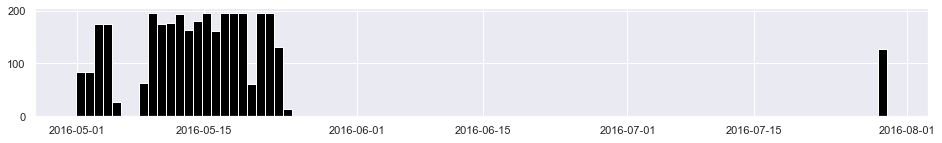

In [38]:
plt.figure(figsize=(16,2))

plt.hist(IS_rt_df['date_time'], bins = 90, color='black')

plt.show()

Plot IS differences over time of measurements

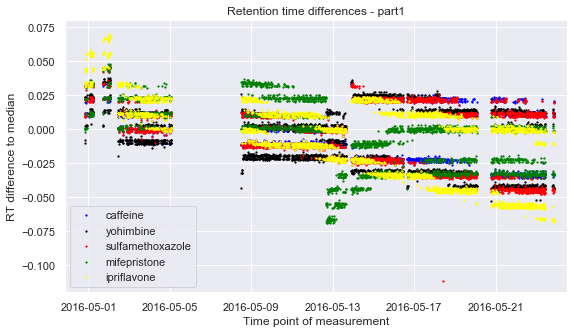

In [72]:
plt.figure(figsize = (9,5))

plt.scatter(IS_rt_df.loc[:,'date_time'], IS_rt_df.loc[:,is_diff_names[2]], s = 1.5, c = 'blue', \
            label = IS_total_names[2])
plt.scatter(IS_rt_df.loc[:,'date_time'], IS_rt_df.loc[:,is_diff_names[3]], s = 1.5, c = 'black', \
            label = IS_total_names[3])
plt.scatter(IS_rt_df.loc[:,'date_time'], IS_rt_df.loc[:,is_diff_names[4]], s = 1.5, c = 'red', \
            label = IS_total_names[4])
plt.scatter(IS_rt_df.loc[:,'date_time'], IS_rt_df.loc[:,is_diff_names[6]], s = 1.5, c = 'green', \
            label = IS_total_names[6])
plt.scatter(IS_rt_df.loc[:,'date_time'], IS_rt_df.loc[:,is_diff_names[7]], s = 1.5, c = 'yellow', \
            label = IS_total_names[7])

#plt.xlim(datetime.strptime('2016-04-29 20:00:00', '%Y-%m-%d %H:%M:%S'),\
#         datetime.strptime('2016-05-24 12:00:00', '%Y-%m-%d %H:%M:%S'))

#plt.ylim(-0.12, 0.08)

#plt.title('Retention time differences - part1')
plt.title('Retention time differences')
plt.xlabel('Time point of measurement')
plt.ylabel('RT difference to median')

plt.legend()

#plt.savefig('intermed_results/02_general_and_IS_stats/'+\
#                'RT_diff_over_time_part1.pdf',\
#                bbox_inches='tight')

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
                'RT_diff_over_time.pdf',\
                bbox_inches='tight')

plt.show()

Colored by strain (table)

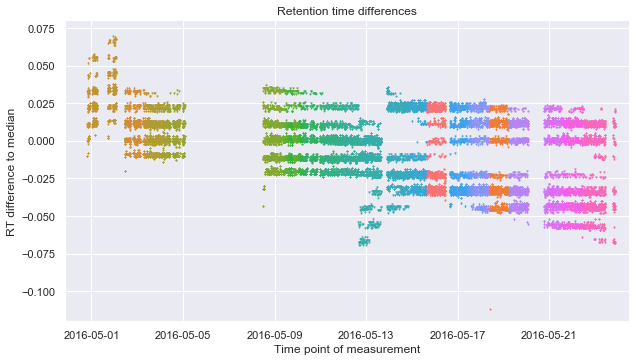

In [92]:
#plt.figure(figsize = (9,5))

fg = sns.FacetGrid(data=IS_rt_df, hue='strain', height = 5, aspect = 9/5, \
                  xlim = (datetime.strptime('2016-04-29 20:00:00', '%Y-%m-%d %H:%M:%S'),\
                          datetime.strptime('2016-05-24 12:00:00', '%Y-%m-%d %H:%M:%S')),\
                          ylim = (-0.12, 0.08))

fg.map(plt.scatter, 'date_time', is_diff_names[2], s = 1.5, marker = 'o') #.add_legend()

fg.map(plt.scatter, 'date_time', is_diff_names[3], s = 1.5, marker = 'x') 

fg.map(plt.scatter, 'date_time', is_diff_names[4], s = 1.5, marker = '*')

fg.map(plt.scatter, 'date_time', is_diff_names[6], s = 1.5, marker = 'v')

fg.map(plt.scatter, 'date_time', is_diff_names[7], s = 1.5, marker = 'd')

#plt.xlim(datetime.strptime('2016-04-29 20:00:00', '%Y-%m-%d %H:%M:%S'),\
#         datetime.strptime('2016-05-24 12:00:00', '%Y-%m-%d %H:%M:%S'))

#plt.ylim(-0.12, 0.08)

#plt.title('Retention time differences - part1')
plt.title('Retention time differences')
plt.xlabel('Time point of measurement')
plt.ylabel('RT difference to median')

#plt.legend()

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
                'RT_diff_over_time_c_example_strain_part1.pdf',\
                bbox_inches='tight')

#plt.savefig('intermed_results/02_general_and_IS_stats/'+\
#                'RT_diff_over_time_c_by_strain.pdf',\
#                bbox_inches='tight')

plt.show()

In [16]:
strain_list = list(strain_info.index)

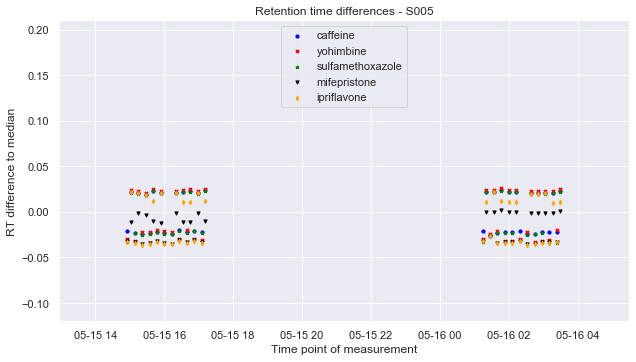

In [185]:
for s in strain_list:

    IS_rt_df_S_selected = IS_rt_df.loc[IS_rt_df['strain']==s,:]


    #plt.figure(figsize = (9,5))

    fg = sns.FacetGrid(data= IS_rt_df_S_selected, height = 5, aspect = 9/5,\
                        xlim = (datetime.strptime(datetime.strftime(min(IS_rt_df_S_selected['date_time']) -\
                                timedelta(hours=2, minutes=0), '%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),\
                              datetime.strptime(datetime.strftime(max(IS_rt_df_S_selected['date_time']) +\
                                timedelta(hours=2, minutes=0), '%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S')),\
                              ylim = (-0.12, 0.21))
                       #-datetime.strptime('06:00:00', '%H:%M:%S'),
                        #+datetime.strptime('06:00:00', '%H:%M:%S')),

    fg.map(plt.scatter, 'date_time', is_diff_names[2], s = 10, marker = 'o', color = 'blue', \
                label = IS_total_names[2]) #.add_legend()

    fg.map(plt.scatter, 'date_time', is_diff_names[3], s = 10, marker = 'x', color = 'red', \
                label = IS_total_names[3]) 

    fg.map(plt.scatter, 'date_time', is_diff_names[4], s = 10, marker = '*', color = 'green', \
                label = IS_total_names[4])

    fg.map(plt.scatter, 'date_time', is_diff_names[6], s = 10, marker = 'v', color = 'black', \
                label = IS_total_names[6])

    fg.map(plt.scatter, 'date_time', is_diff_names[7], s = 10, marker = 'd', color = 'orange', \
                label = IS_total_names[7])

    #plt.xlim(datetime.strptime('2016-04-29 20:00:00', '%Y-%m-%d %H:%M:%S'),\
    #         datetime.strptime('2016-05-24 12:00:00', '%Y-%m-%d %H:%M:%S'))

    #plt.ylim(-0.12, 0.08)

    #plt.title('Retention time differences - part1')
    plt.title('Retention time differences - '+s)
    plt.xlabel('Time point of measurement')
    plt.ylabel('RT difference to median')

    plt.legend(loc = 9)

    plt.savefig('intermed_results/02_general_and_IS_stats/IS_RT_per_strain/'+\
                    'RT_diff_over_time_c_strain_'+s+'.pdf',\
                    bbox_inches='tight')

    if s == 'S005':
        plt.show()

    plt.close('all')

    #plt.savefig('intermed_results/02_general_and_IS_stats/'+\
    #                'RT_diff_over_time_c_by_strain.pdf',\
    #                bbox_inches='tight')



Separate plotting of the outlier S085

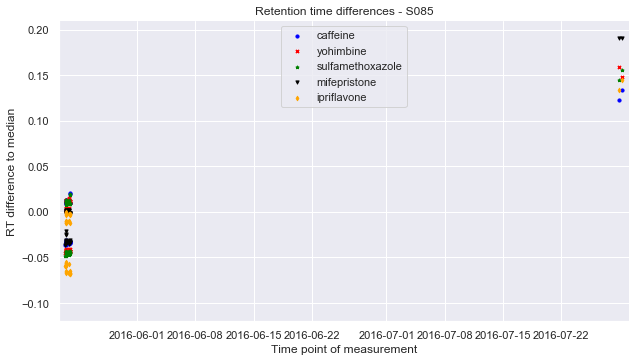

In [183]:
#separate plotting of outlier S085

s = 'S085'

IS_rt_df_S_selected = IS_rt_df.loc[IS_rt_df['strain']==s,:]


#plt.figure(figsize = (9,5))

fg = sns.FacetGrid(data= IS_rt_df_S_selected, height = 5, aspect = 9/5,\
                    xlim = (datetime.strptime(datetime.strftime(min(IS_rt_df_S_selected['date_time']) -\
                            timedelta(hours=20, minutes=0), '%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S'),\
                          datetime.strptime(datetime.strftime(max(IS_rt_df_S_selected['date_time']) +\
                            timedelta(hours=20, minutes=0), '%Y-%m-%d %H:%M:%S'),'%Y-%m-%d %H:%M:%S')),\
                          ylim = (-0.12, 0.21))
                   #-datetime.strptime('06:00:00', '%H:%M:%S'),
                    #+datetime.strptime('06:00:00', '%H:%M:%S')),

fg.map(plt.scatter, 'date_time', is_diff_names[2], s = 10, marker = 'o', color = 'blue', \
            label = IS_total_names[2]) #.add_legend()

fg.map(plt.scatter, 'date_time', is_diff_names[3], s = 10, marker = 'x', color = 'red', \
            label = IS_total_names[3]) 

fg.map(plt.scatter, 'date_time', is_diff_names[4], s = 10, marker = '*', color = 'green', \
            label = IS_total_names[4])

fg.map(plt.scatter, 'date_time', is_diff_names[6], s = 10, marker = 'v', color = 'black', \
            label = IS_total_names[6])

fg.map(plt.scatter, 'date_time', is_diff_names[7], s = 10, marker = 'd', color = 'orange', \
            label = IS_total_names[7])

#plt.xlim(datetime.strptime('2016-04-29 20:00:00', '%Y-%m-%d %H:%M:%S'),\
#         datetime.strptime('2016-05-24 12:00:00', '%Y-%m-%d %H:%M:%S'))

#plt.ylim(-0.12, 0.08)

#plt.title('Retention time differences - part1')
plt.title('Retention time differences - '+s)
plt.xlabel('Time point of measurement')
plt.ylabel('RT difference to median')

plt.legend(loc = 9)

plt.savefig('intermed_results/02_general_and_IS_stats/IS_RT_per_strain/'+\
                'RT_diff_over_time_c_strain_'+s+'_outlier.pdf',\
                bbox_inches='tight')

plt.show()

plt.close('all')

#plt.savefig('intermed_results/02_general_and_IS_stats/'+\
#                'RT_diff_over_time_c_by_strain.pdf',\
#                bbox_inches='tight')



Include drugs in visualization

In [17]:
# Get median of each drug (incl IS rows)

comp_vals = []

for comp in targeted_perS_list[0].index:
    
    table_vals = []
    
    for cur_table in targeted_perS_list:
        vals = list(cur_table.loc[comp,cur_table.columns.str.endswith('RT')])
        table_vals.extend(vals)
     
    comp_vals.append(table_vals)


In [38]:
med_df = pd.DataFrame(index = targeted_perS_list[0].index, columns = ['RT_median'])

med_df['RT_median'] = [np.nanmedian(vals) for vals in comp_vals]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [39]:
for cur_table in targeted_perS_list:
    
    table_RTs = cur_table.loc[:,cur_table.columns.str.endswith('RT')].copy()
    
    for comp in table_RTs.index:
        
        table_RTs.loc[comp,:] = table_RTs.loc[comp,:]-med_df.loc[comp, 'RT_median']
    
    med_df = pd.merge(med_df, table_RTs, how = 'left', left_index=True, right_index=True)


In [47]:
# transpose med_df
all_comp_rt_df = med_df.transpose()

In [48]:
# remove med row
all_comp_rt_df = all_comp_rt_df.loc[all_comp_rt_df.index != 'RT_median',:]

In [49]:
all_comp_rt_df.index = [idx_str[:-3] for idx_str in all_comp_rt_df.index]

In [50]:
# add time stamp to rt data frame
t_stamp_col = []

for idx in all_comp_rt_df.index:
    t_stamp_col.append(time_info.loc[idx, 'date_time'])

all_comp_rt_df['date_time'] = t_stamp_col

In [51]:
# add strain as column
strain_col = []

for idx in all_comp_rt_df.index:
    strain_col.append(idx.split('-')[3])

all_comp_rt_df['strain'] = strain_col


Plot RT-diffs as function of RT median

In [95]:
intresting_cols =[s for s in med_df.columns if 'S087' in s]

In [96]:
for i, col in enumerate(intresting_cols): #range(1, med_df.shape[1])
    
    strain = col.split('-')[3]
    pool = col.split('-')[1]
    TP = col.split('-')[4]
    
    plt.scatter(med_df['RT_median'], med_df[col])

    plt.ylim(-0.5, 0.5)

    plt.title('Presence of RT shifts - '+strain+' - '+pool+' - '+TP)
    plt.xlabel('RT [min]')
    plt.ylabel('RT difference to median')
    
    plt.savefig('intermed_results/02_general_and_IS_stats/RT_shifts_per_measurement/'+\
                'RT_diff_over_med_'+strain+'_'+str(i)+'.pdf',\
                bbox_inches='tight')
    
    plt.close('all')

Violin plots of RT distribution in untargeted data

In [100]:
# example S021 vs S087

check_df_S021 = untargeted_perS_list[strain_list.index('S021')]
check_df_S085 = untargeted_perS_list[strain_list.index('S085')]

In [123]:
y1 = list(check_df_S021['RT'])
y2 = list(check_df_S085['RT'])

dat_list = [y1, y2]

#RT_val_dict = {'S021': list(check_df_S021['RT']), 'S085': list(check_df_S085['RT'])}

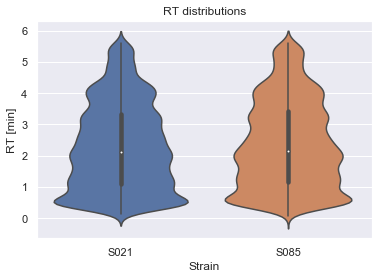

In [130]:
g = sns.violinplot(data = dat_list )

g.set(xticklabels=['S021', 'S085'])

plt.title('RT distributions')
plt.xlabel('Strain')
plt.ylabel('RT [min]')

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
            'RT_distr_comp.pdf',\
            bbox_inches='tight')

Plot RT differences of targeted compounds

In [155]:
# get x-y of RT and difference for each strain

RT_diffs_per_strain = []

for strain in strain_list:
    
    intresting_cols = [s for s in med_df.columns if strain in s]

    data_vals = med_df.loc[:, intresting_cols].to_numpy().flatten()
    data_vals = data_vals[~np.isnan(data_vals)]
    
    RT_diffs_per_strain.append(data_vals)



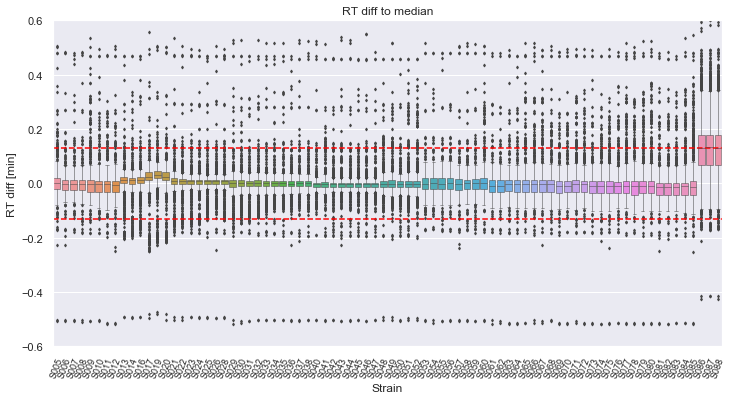

In [179]:
plt.figure(figsize = (12,6))
#sns.violinplot(data = RT_diffs_per_strain, orient = 'v')
bp = sns.boxplot(data = RT_diffs_per_strain, fliersize = 2, linewidth = 0.5)

bp.set_xticklabels(labels=strain_list, rotation = 70, size = 9)

bp.set_ylim(-0.6, 0.6)

bp.axhline(-0.13, ls='--', color = 'red')
bp.axhline(0.13, ls='--', color = 'red')

plt.title('RT diff to median')
plt.xlabel('Strain')
plt.ylabel('RT diff [min]')

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
            'RT_diff_across_strains_0.6ylim.pdf',\
            bbox_inches='tight')

plt.show()

plt.close('all')



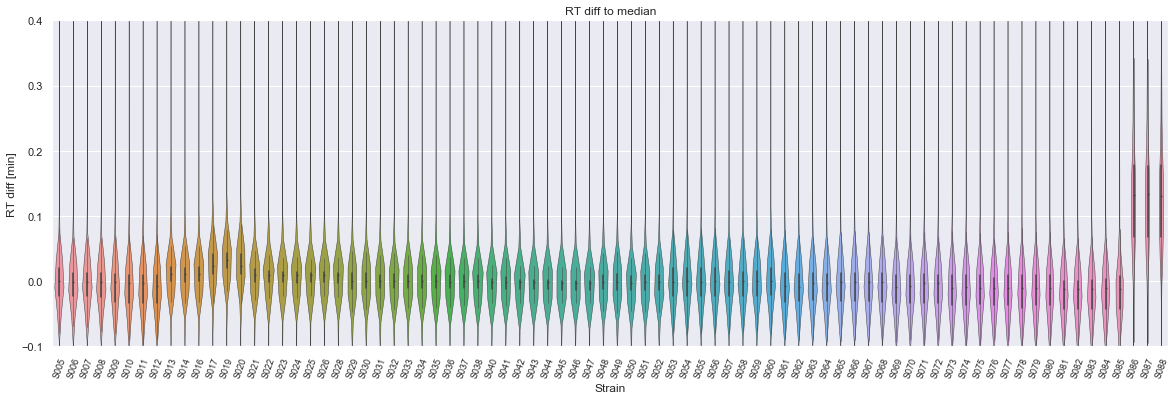

In [177]:
plt.figure(figsize = (20,6))
#sns.violinplot(data = RT_diffs_per_strain, orient = 'v')
bp = sns.violinplot(data = RT_diffs_per_strain, fliersize = 2, linewidth = 0.5)

bp.set_xticklabels(labels=strain_list, rotation = 70, size = 9)

bp.set_ylim(-0.1, 0.4)

plt.title('RT diff to median')
plt.xlabel('Strain')
plt.ylabel('RT diff [min]')

plt.savefig('intermed_results/02_general_and_IS_stats/'+\
            'RT_diff_across_strains_violin.pdf',\
            bbox_inches='tight')

plt.show()

plt.close('all')

